In [14]:
from models_and_tools.ACGAN_paper import *
from models_and_tools.ACGAN_simple import *
from models_and_tools.functions import *
from skimage.metrics import structural_similarity as ssim
device = 'cuda'

Downloading the model and parameters

In [15]:
netG = Generator(conf).to(device)
netD = Discriminator(conf).to(device)
# Load the weights back into the models
netG.load_state_dict(torch.load('netG_lr3.pth'))
netD.load_state_dict(torch.load('netD_lr3.pth'))
# Make sure to call eval() if you're in inference mode
netG.eval()
netD.eval()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.5, inplace=False)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout(p=0.5, inplace=False)
    (15): Conv2d(128, 

Defining functions required for the SSIM score calculations

In [16]:
def rgb_to_grayscale_numpy(image):
	"""
	Convert an RGB image to a grayscale image using the luminosity method.
	Parameters:
		image (numpy.ndarray): The RGB image in CHW format.
	Returns:
		numpy.ndarray: The grayscale image in 1HW format (1 channel, Height, Width).
	"""
	if image.shape[0] == 3:  # Check if the input image has 3 channels (RGB)
		image = image.transpose(1, 2, 0)  # Convert to HWC format for easier processing
	# Apply the luminosity method to calculate grayscale values
	grayscale = 0.2989 * image[:, :, 0] + 0.5870 * image[:, :, 1] + 0.1140 * image[:, :, 2]
	return grayscale[np.newaxis, :, :]  # Add channel dimension back for consistency


def calculate_ssim(image1, image2):
	"""
    Calculate the Structural Similarity Index Measure (SSIM) between two images.
    Parameters:
        image1, image2 (numpy.ndarray or torch.Tensor): The input images.
    Returns:
        float: The SSIM index between the two input images.
    """
	# Convert PyTorch tensors to numpy arrays if necessary
	if torch.is_tensor(image1):
		image1 = image1.cpu().numpy()  # CHW to HWC
	if torch.is_tensor(image2):
		image2 = image2.cpu().numpy()  # CHW to HWC
	# Convert images to grayscale
	image1 = rgb_to_grayscale_numpy(image1)[0]
	image2 = rgb_to_grayscale_numpy(image2)[0]
	# Normalize images to ensure they are compared on the same scale
	image1 = (image1 - image1.min()) / (image1.max() - image1.min())
	image2 = (image2 - image2.min()) / (image2.max() - image2.min())
	# Calculate and return the SSIM
	ssim_value = ssim(image1, image2, multichannel=False, data_range=1)
	return ssim_value

Here we need to generate 2 times 1000 images using our GAN model. For AC-GAN it's a little bit different compared to  normal GANS.

In [17]:
num_images_acc = 1000  # number of images
noise = torch.randn(num_images_acc, 100, device=device)  #noise for images
# creating labels (required only for AC-GAM)
fake_labels = torch.randint(0, conf.num_classes, (num_images_acc,), device=device)
fake_labels_oh = torch.nn.functional.one_hot(fake_labels, num_classes=10)  # one-hot representation
# generating images - 1st pack
fake_images = netG(noise, fake_labels_oh).detach()
# Now repeating the same procedure for the 2nd pack of the images
noise2 = torch.randn(num_images_acc, 100, device=device)
fake_labels2 = fake_labels
fake_labels_oh2 = torch.nn.functional.one_hot(fake_labels, num_classes=10)
# generating images - 1st pack
fake_images2 = netG(noise2, fake_labels_oh2).detach()
# Calculate SSIM for each pair


In [18]:
ssim_scores = []
for gen_img, gen_img2 in zip(fake_images, fake_images2):  # 2 packs pairwise
	current_ssim = calculate_ssim(gen_img, gen_img2)
	ssim_scores.append(current_ssim)

average_ssim_ACGAN = np.mean(ssim_scores)
print(f"Average SSIM (AC-GAN): {average_ssim_ACGAN}")

Average SSIM (AC-GAN): 0.10445743877513672


Doing the same for AC-GAN with a simple structure

In [19]:
netGs = Generator_simple().to(device)
netDs = Discriminator_simple().to(device)
# Load the weights back into the models
netGs.load_state_dict(torch.load('netG_simple.pth'))
netDs.load_state_dict(torch.load('netD_simple.pth'))
# Make sure to call eval() if you're in inference mode
netGs.eval()
netDs.eval()

Discriminator_simple(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (img_real): Sequential(
    (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
    (1): Sigmoid()
  )
  (classification): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [20]:
num_images_acc = 1000  # number of images
noise = torch.randn(num_images_acc, 100, device=device)  #noise for images
# creating labels (required only for AC-GAM)
fake_labels = torch.randint(0, conf.num_classes, (num_images_acc,), device=device)
fake_labels_oh = torch.nn.functional.one_hot(fake_labels, num_classes=10)  # one-hot representation
# generating images - 1st pack
fake_images = netGs(noise, fake_labels_oh).detach()
# Now repeating the same procedure for the 2nd pack of the images
noise2 = torch.randn(num_images_acc, 100, device=device)
fake_labels2 = fake_labels
fake_labels_oh2 = torch.nn.functional.one_hot(fake_labels, num_classes=10)
# generating images - 1st pack
fake_images2 = netGs(noise2, fake_labels_oh2).detach()
# Calculate SSIM for each pair
ssim_scores = []
for gen_img, gen_img2 in zip(fake_images, fake_images2):  # 2 packs pairwise
	current_ssim = calculate_ssim(gen_img, gen_img2)
	ssim_scores.append(current_ssim)

average_ssim_ACGAN_simple = np.mean(ssim_scores)
print(f"Average SSIM (AC-GAN): {average_ssim_ACGAN_simple}")

Average SSIM (AC-GAN): 0.07039065909178464


Calculating SSIM score for pure CIFAR10 dataset (not generated images) as a reference

In [21]:
transform = transforms.Compose([
	transforms.Resize((conf.img_size, conf.img_size)),  # Resize the image
	 transforms.ToTensor(),  # Convert the image to a tensor
	 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the tensor
])
# downloading the CIFAR10 dataset
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=conf.batch_size, shuffle=True)
# getting images from the train dataset
real_images1, real_labels1 = get_images_labels(num_images_acc, train_loader)
real_images2, real_labels2 = get_images_labels(num_images_acc, train_loader)
# calculating the score
ssim_scores = []
for gen_img, gen_img2 in zip(real_images1, real_images2):  # 2 packs pairwise
	current_ssim = calculate_ssim(gen_img, gen_img2)
	ssim_scores.append(current_ssim)

average_ssim_CIFAR10 = np.mean(ssim_scores)
print(f"average_ssim_CIFAR10: {average_ssim_CIFAR10}")

Files already downloaded and verified
average_ssim_CIFAR10: 0.03082763445877288


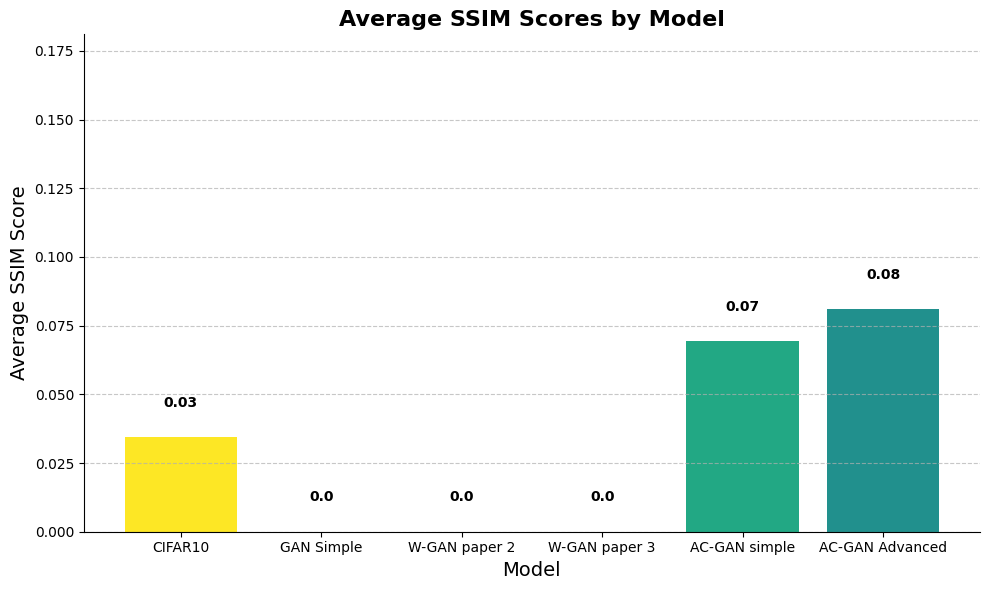

In [22]:

# Update last model name accordingly !!!!!!!!!!!!
model_names = ['CIFAR10', 'GAN Simple', 'W-GAN paper 2', 'W-GAN paper 3', 'AC-GAN simple', 'AC-GAN Advanced']
avg_ssim_scores = [0.0343, 0, 0, 0, 0.06940723189351997, 0.081]  # actual average SSIM scores

# Choose a color palette for the bars
colors = plt.cm.viridis_r(np.linspace(0, 0.5, len(model_names)))

# Set up the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, avg_ssim_scores, color=colors)

# Add the SSIM scores on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', color='black', weight='bold')

# Set the title and labels
plt.title('Average SSIM Scores by Model', fontsize=16, fontweight='bold')
plt.xlabel('Model', fontsize=14)
plt.ylabel('Average SSIM Score', fontsize=14)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set the ylim to better show the text
plt.ylim(0, max(avg_ssim_scores) + 0.1)  # Adjust based on your scores

# Remove the top and right spines for aesthetics
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Improve layout and display the plot
plt.tight_layout()
plt.show()

Now let's calculate specific to AC-GAN class-dependent SSIM scores

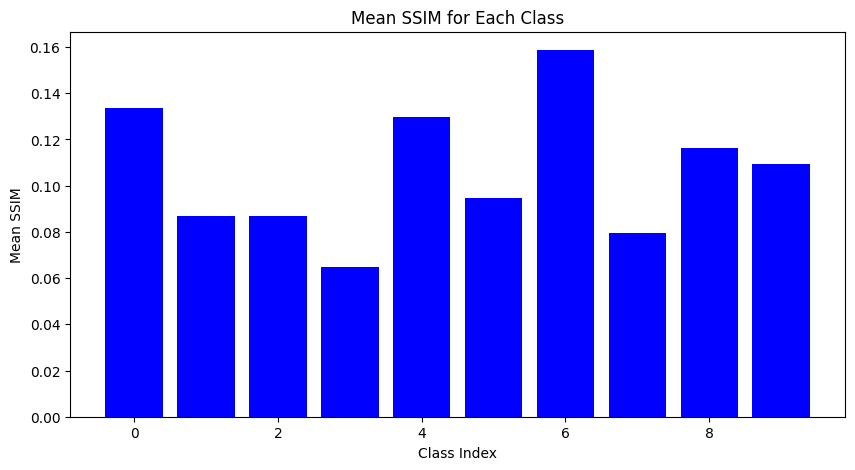

In [23]:
num_classes = 10
num_examples_per_class = 100
mean = 1
mean_ssims = []  # saving SSIM scores for each class

for class_idx in range(num_classes):  # iterating over each class
	# Generate two sets of images for each class
	noise1 = torch.randn(num_examples_per_class, 100, device=device)
	noise2 = torch.randn(num_examples_per_class, 100, device=device)
	labels = torch.full((num_examples_per_class,), class_idx, device=device)
	labels_oh = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()

	images1 = netG(noise1, labels_oh).detach()
	images2 = netG(noise2, labels_oh).detach()

	ssims = []
	for img1, img2 in zip(images1, images2):
		current_ssim = calculate_ssim(img1, img2)
		ssims.append(current_ssim)

	mean_ssim = np.mean(ssims)
	mean_ssims.append(mean_ssim)
	# print(f"Class {class_idx} Mean SSIM: {mean_ssim}")
mean = np.mean(mean_ssims)

# Plot the mean SSIM values
plt.figure(figsize=(10, 5))
plt.bar(range(num_classes), mean_ssims, color='blue')
plt.xlabel('Class Index')
plt.ylabel('Mean SSIM')
plt.title('Mean SSIM for Each Class')
plt.show()

As a reference, let's calculate SSIM scores for the original dataset

In [24]:
def get_n_images_of_class(images, labels, class_x, n):
	"""
    Fetches N images of a specified class X from the image and label arrays.
    Returns:
    - selected_images (numpy array): An array of N images belonging to class X.
    """
	indices_of_class_x = np.where(labels == class_x)[0]
	# Check if there are enough samples of class_x
	if len(indices_of_class_x) < n:
		print(
			f"Warning: Only {len(indices_of_class_x)} images found for class {class_x}, which is less than {n} requested.")
		n = len(indices_of_class_x)  # Adjust n to the maximum available if less than requested
	# Randomly select n indices from those that belong to class_x
	selected_indices = np.random.choice(indices_of_class_x, n, replace=False)
	# Fetch the images corresponding to these indices
	selected_images = images[selected_indices]
	return selected_images

# getting 10000 images from the CIFAR10 dataset
images_train, labels_train = get_images_labels(10000, train_loader)

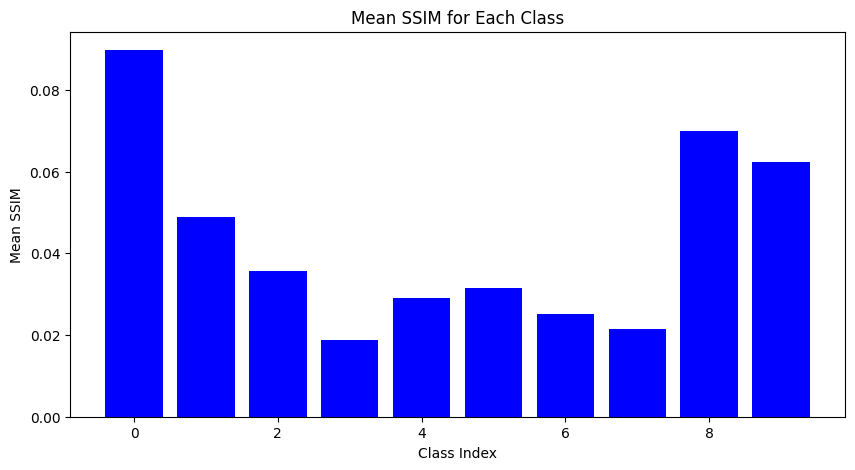

In [25]:
num_classes = 10
num_examples_per_class = 100

mean_ssims_train = []
for class_idx in range(num_classes):  # iterating over all image classes
	# getting images of the class we need at this cicle
	images = get_n_images_of_class(images_train, labels_train, class_idx, num_examples_per_class * 2)
	images1 = images[:num_examples_per_class]
	images2 = images[num_examples_per_class:]

	ssims = []
	for img1, img2 in zip(images1, images2):
		current_ssim = calculate_ssim(img1, img2)
		ssims.append(current_ssim)

	mean_ssim = np.mean(ssims)
	mean_ssims_train.append(mean_ssim)
	# print(f"Class {class_idx} Mean SSIM: {mean_ssim}")
mean = np.mean(mean_ssims_train)
maxv = np.max(mean_ssims_train)
# Optional: Plot the mean SSIM values
plt.figure(figsize=(10, 5))
plt.bar(range(num_classes), mean_ssims_train, color='blue')
plt.xlabel('Class Index')
plt.ylabel('Mean SSIM')
plt.title('Mean SSIM for Each Class')
plt.show()

Plotting and interpreting results of SSIM scores fore AC-GAN and CIFAR10 dataset

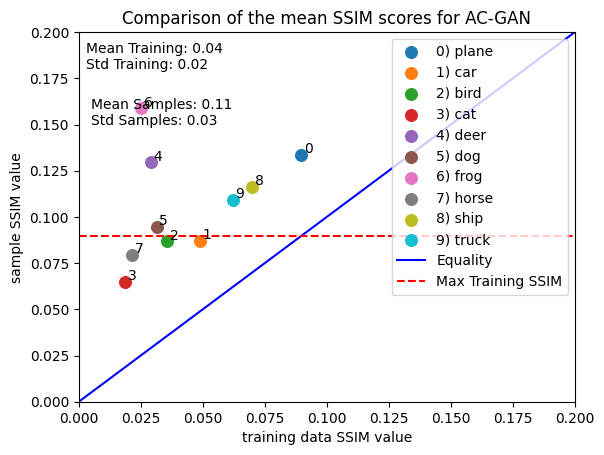

In [28]:
fig, ax = plt.subplots()

# calculating mean values and std errors
mean_train = np.mean(mean_ssims_train)
std_train = np.std(mean_ssims_train)
mean_samples = np.mean(mean_ssims)
std_samples = np.std(mean_ssims)

# Create scatter plot
for i in range(len(mean_ssims_train)):
	# each class has its own number and color
    ax.scatter(mean_ssims_train[i], mean_ssims[i], label=f'{i}) {classes[i]}', s=70)
    ax.text(mean_ssims_train[i] + 0.001, mean_ssims[i] + 0.001, f'{i}', fontsize=10)

# Plot the line of equality
plt.plot([0, 0.2], [0, 0.2], 'b-', label='Equality')
# Plot the maximum SSIM value line
plt.axhline(y=max(mean_ssims_train), color='r', linestyle='--', label='Max Training SSIM')

# Annotations for mean and standard deviation
plt.text(0.003, 0.18, f'Mean Training: {mean_train:.2f}\nStd Training: {std_train:.2f}', color='black')
plt.text(0.005, 0.15, f'Mean Samples: {mean_samples:.2f}\nStd Samples: {std_samples:.2f}', color='black')
# Labels and title
plt.xlabel('training data SSIM value')
plt.ylabel('sample SSIM value')
plt.title('Comparison of the mean SSIM scores for AC-GAN')
plt.xlim(0.0, 0.2)
plt.ylim(0.0, 0.2)
# Legend
plt.legend()
# Show the plot
plt.show()